# Image Processing 05

```
from IPython import display
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from skimage import data
from skimage import color
from skimage.color import label2rgb
from skimage.filters import try_all_threshold, threshold_otsu, threshold_local, sobel, gaussian
from skimage import exposure
from skimage.transform import rotate, resize, rescale
from skimage import morphology
from skimage.restoration import inpaint, denoise_tv_chambolle, denoise_bilateral
from skimage.util import random_noise
from skimage.segmentation import slic
from skimage import measure
from skimage.io import imread
from skimage.feature import canny, corner_harris, corner_peaks, Cascade
```

In [1]:
from IPython import display
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from skimage import data
from skimage import color
from skimage.color import label2rgb
from skimage.color import rgba2rgb, rgb2gray
from skimage.filters import try_all_threshold, threshold_otsu, threshold_local, sobel, gaussian
#from skimage import exposure
#from skimage.transform import rotate, resize, rescale
#from skimage import morphology
#from skimage.restoration import inpaint, denoise_tv_chambolle, denoise_bilateral
#from skimage.util import random_noise
from skimage.segmentation import slic
from skimage import measure
from skimage.io import imread
from skimage.feature import canny, corner_harris, corner_peaks, Cascade

In [2]:
def show_image(image, title='Image', cmap_type='gray'):
    plt.imshow(image, cmap=cmap_type)
    plt.title(title)
    plt.axis('off')
    plt.show()

In [3]:
def plot_comparison(original, original_title, filtered, title_filtered):
    
    fig, (ax1, ax2) = plt.subplots(ncols= 2, figsize=(12, 8), sharex= True, sharey= True)
    ax1.imshow(original, cmap = plt.cm.gray)
    ax1.set_title(original_title)
    ax1.axis('off')
    ax2.imshow(filtered, cmap= plt.cm.gray)
    ax2.set_title(title_filtered)
    ax2.axis('off')

In [4]:
def show_image_contour(image, contours):
    plt.figure()
    for n, contour in enumerate(contours):
        plt.plot(contour[:,1], contour[:,0], linewidth=3)
    plt.imshow(image, interpolation='nearest', cmap='gray_r')
    plt.title('Contours')
    plt.axis('off')

In [5]:
def show_image_with_corners(image, coords, title="Corners detected"):
    plt.imshow(image, interpolation='nearest', cmap='gray')
    plt.title(title)
    plt.plot(coords[:, 1], coords[:, 0], '+r', markersize=15)
    plt.axis('off')
    plt.show()

In [6]:
def show_detected_face(result, detected, title="Face image"):
    plt.figure()
    plt.imshow(result)
    img_desc = plt.gca()
    plt.set_cmap('gray')
    plt.title(title)
    plt.axis('off')

    for patch in detected:
        
        img_desc.add_patch(
            patches.Rectangle(
                (patch['c'], patch['r']),
                patch['width'],
                patch['height'],
                fill=False,
                color='r',
                linewidth=2)
        )
    plt.show()
    crop_face(result, detected)

In [7]:
def crop_face(result, detected, title ='Face detected'):
    for d in detected:
        print(d)
        face = result[d['r'] : d['r']+ d['width'], d['c'] : d['c']+ d['height']]
        
        plt.figure(figsize= (8,6))
        plt.imshow(face)
        plt.title(title)
        plt.axis('off')
        plt.show()

In [8]:
def getFace(d):
    ''' Extracts the face rectangle from the image using the coordinates of the detected.'''
    # X and Y starting points of the face rectangle
    x, y = d['r'], d['c']
    
    # Add the width and height of the face rectangle to complete
    width, height = d['r'] + d['width'], d['c'] + d['height']
    
    # Extract the detected face
    face = image[x: width, y: height]
    return face

In [9]:
def getFaceRectangle(image, d):
    ''' Extracts the face from the image using the coordinates of the detected image '''
    # X and Y starting points of the face rectangle
    x, y = d['r'], d['c']
    
    # Add the width and height of the face rectangle to complete
    width, height = d['r'] + d['width'], d['c'] + d['height']
    
    # Extract the detected face
    face = image[x: width, y: height]
    return face

In [10]:
def mergeBlurryFace(original, gaussian_image):
    # X and Y starting points of the face rectangle
    x, y = d['r'], d['c']
    
    # The width and height of the face rectangle
    width, height = d['r'] + d['width'], d['c'] + d['height']
    
    original[x: width, y: height] = gaussian_image
    return original

# Face Detection
* In recent years, face detection has attracted a lot of attention and had a big impact on automated processes through artificial vision.
* In this subunit, we'll learn how to perform face detection using out-of-the-box functions from `skimage`.

#### Face detection use cases
* Several social network platforms and smart-phones are using face detection to know if there is someone in a picture and, if so, apply filters, add focus to the face area, or recommend you tag friends. 
* Face detection use cases:
    * Filters
    * Auto focus
    * Tag recommendations
    * Automatically blur faces for privacy protection
    * To recognize emotions later on
    
* Face detection is the key first step before recognizing emotions

#### Detecting faces with `skimage`
* With `skimage`, we can detect faces using a machine learning classifier, with just a few lines of code!
* In this course we don't cover ML concepts in depth, but it's important to know that we use a **cascade of classifiers**, which is like multiple classifiers in one.
* You can also use it for other things, like cats, objects, or profiled faces (from a side view).
* **Note:** the following face detection framework requires an **xml file**, from which the trained data can be read. 

```
# Import the classifier class
from skimage.feature import Cascade

# Load the trained file from the module root
trained_file = data.lbp_frontal_face_cascade_filename()

# Initialize the detector cascade
detector = Cascade(trained_file)
```
* To apply the detector on images, we need to use the `detect_multi_scale` method from the same cascade class.
* This method searches for the object (in this case a face)
* It creates a window that will be moving through the image until it finds something similar to a human face
* **Searching happens on multiple scales**
* **The window will have a minimum size** to spot small or far-away faces
* **The window will have a maximum size** to also find the larger faces in the image

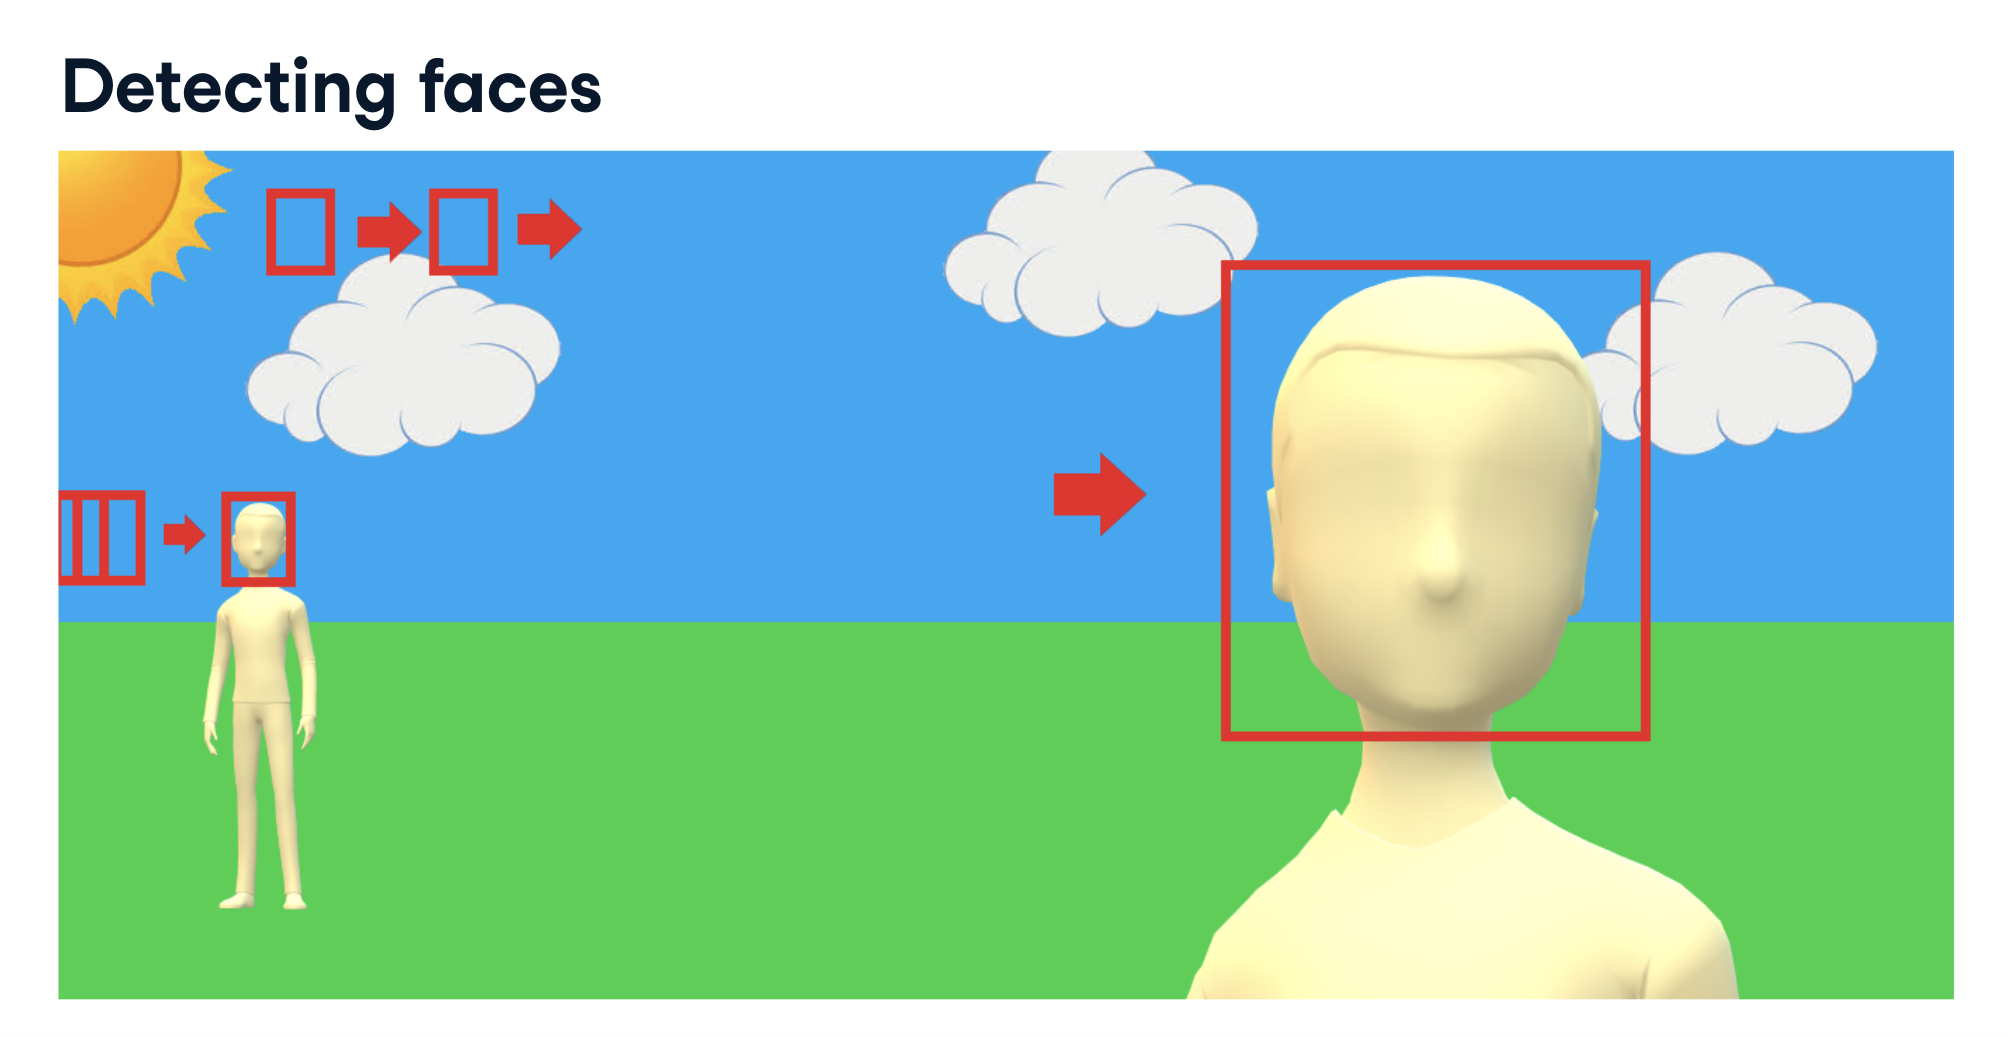

In [11]:
display.Image("pics/detect_multi_scale_faces.png")

* This method takes:
    * **input image** (`img`) as the first parameter
    * **scale factor** (`scale_factor`) by which the search window is multiplied in each step
    * **step ratio** (`step_ratio`), in which 1 represents an exhaustive search and usually is slow
        * By setting this parameter to high values, the results will be worse but the computation will be much faster
        * Usually, values in the interval of 1.0-1.5 give good results
    * **minimum window size:** (`min_size`) specifies the minimum size of search windows that are applied to the input image to detect faces
    * **maximum window side:** (`max_size`) specifies the maximum size of search windows that are applied to the input image to detect faces

```
# Apply detector on the image
detected = detector.detect_multi_scale(img= image,
                                       scale_factor= 1.2,
                                       step_ratio= 1,
                                       min_size = (10, 10),
                                       max_size = (200, 200))                                                         
```
* The detector will return the coordinates of the box that contains the face.
* When printing the result, we see that it is a **dictionary**, where `r` represents the row position of the top left corner of the detected window, and and `c` is the column position of the top left corner of the detected window
* `width` is the width of the detected window and `height` is the height of the detected window.

```
print(detected)
# Show image with detected face marked
show_detected_face(image, detected)
```
* OUTPUT: `Detected face: [{'r': 115, 'c': 210, 'width': 167, 'height': 167}]`
* We then use a function that shows the original image with the detected face marked with red lines, forming a box containing the face.
* The above-defined function, **`show_detected_face`** draws a rectangle around detected faces.

```
# Load the trained file from data
trained_file = data.lbp_frontal_face_cascade_filename()

# Initialize the detector cascade
detector = Cascade(trained_file)

# Detect faces with min and max size of searching window
detected = detector.detect_multi_scale(img = night_image,
                                       scale_factor=1.2,
                                       step_ratio=1,
                                       min_size=(10,10),
                                       max_size=(200,200))

# Show the detected faces
show_detected_face(night_image, detected)
```

In [12]:
night_image = imread('pics/night_image.png')

<ipython-input-13-bdd93b1a3d6c>:4: FutureWarning: Non RGB image conversion is now deprecated. For RGBA images, please use rgb2gray(rgba2rgb(rgb)) instead. In version 0.19, a ValueError will be raised if input image last dimension length is not 3.
  detected = detector.detect_multi_scale(img = night_image,


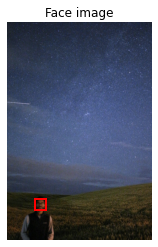

{'r': 797, 'c': 127, 'width': 47, 'height': 47}


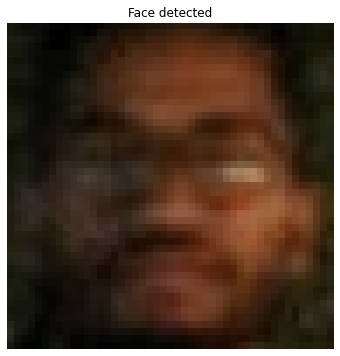

In [13]:
# Load the trained file from data
trained_file = data.lbp_frontal_face_cascade_filename()
detector = Cascade(trained_file)
detected = detector.detect_multi_scale(img = night_image,
                                       scale_factor = 1.2,
                                       step_ratio = 1,
                                       min_size = (10,10),
                                       max_size=(200, 200))
show_detected_face(night_image, detected)

#### Multiple faces
In this exercise, you will detect multiple faces in an image and show them individually.

In [14]:
friends_image = imread('pics/friends_image.png')

<ipython-input-22-adde9901a1b3>:8: FutureWarning: Non RGB image conversion is now deprecated. For RGBA images, please use rgb2gray(rgba2rgb(rgb)) instead. In version 0.19, a ValueError will be raised if input image last dimension length is not 3.
  detected = detector.detect_multi_scale(img = friends_image,


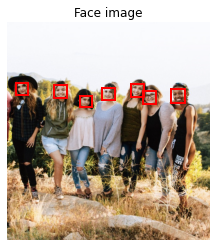

{'r': 294, 'c': 219, 'width': 61, 'height': 61}


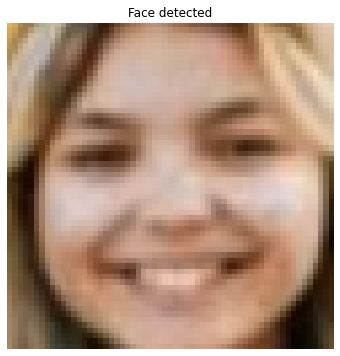

{'r': 286, 'c': 576, 'width': 62, 'height': 62}


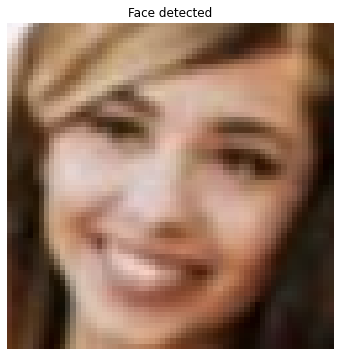

{'r': 304, 'c': 442, 'width': 59, 'height': 59}


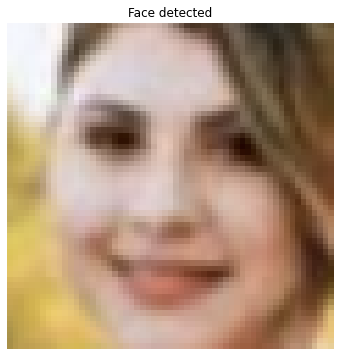

{'r': 312, 'c': 764, 'width': 65, 'height': 65}


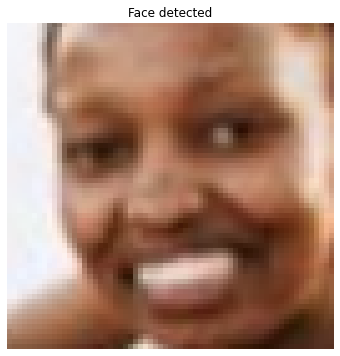

{'r': 318, 'c': 633, 'width': 61, 'height': 61}


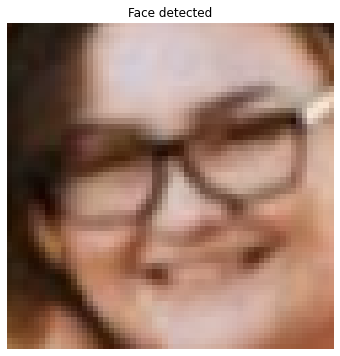

{'r': 282, 'c': 41, 'width': 55, 'height': 55}


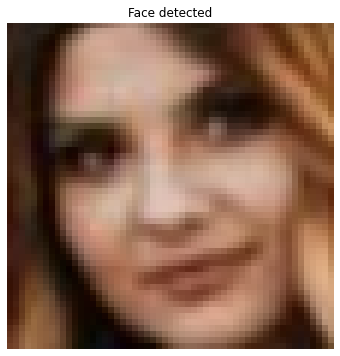

{'r': 343, 'c': 340, 'width': 54, 'height': 54}


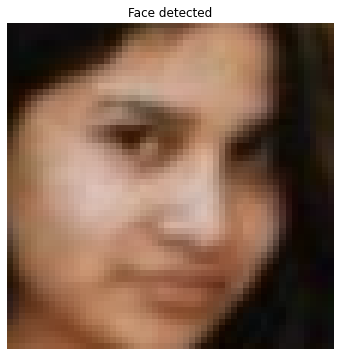

In [22]:
# Load the trained file
# trained_file = data.lbp_frontal_face_cascade_filename()

# Initialize the detector cascade
detector = Cascade(trained_file)

# Detect faces with scale factor to 1.2 and step ratio to 1
detected = detector.detect_multi_scale(img = friends_image, 
                                       scale_factor = 1.2, 
                                       step_ratio = 1, 
                                       min_size = (10, 10), 
                                       max_size = (200, 200))

# Show the detected faces
show_detected_face(friends_image, detected)

### Segmentation and face detection 
Previously, you learned how to make processes more computationally efficient with unsupervised superpixel segmentation. In this exercise, you'll do just that!

Using the slic() function for segmentation, pre-process the image before passing it to the face detector.

[skimage.color documentation](https://scikit-image.org/docs/dev/api/skimage.color.html#skimage.color.label2rgb)
* Note new FutureWarnings: **must specify `slic(start_label=1)` and `labelrgb(bg_label=0)`**
* **Use either:**
    * **`show_image(segmented_image/255)`**
    * **OR**
    * **`show_image(np.array(segmented_image, np.int32))`**
* See this [StackOverflow](https://stackoverflow.com/questions/49643907/clipping-input-data-to-the-valid-range-for-imshow-with-rgb-data-0-1-for-floa) for helpful troubleshooting with latest updates

```
# Obtain the segmentation with default 100 regions
segments = slic(profile_image)

# Obtain segmented image using label2rgb
segmented_image = label2rgb(segments, profile_image, kind='avg')

# Detect the faces with multi scale method
detected = detector.detect_multi_scale(img=segmented_image, 
                                       scale_factor=1.2, 
                                       step_ratio=1, 
                                       min_size=(10, 10), max_size=(1000, 1000))

# Show the detected faces
show_detected_face(segmented_image, detected)
```

In [16]:
rebeca_image = imread('pics/rebeca_image.png')

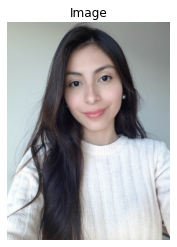

In [17]:
show_image(rebeca_image)

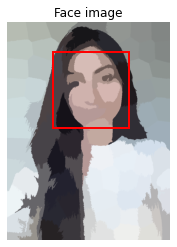

{'r': 137, 'c': 213, 'width': 356, 'height': 356}


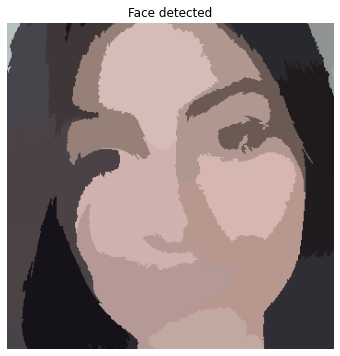

In [18]:
# Obtain the segmentation with default 100 regions
segments = slic(rgba2rgb(rebeca_image), start_label = 1)

# Obtain segmented image using label2rgb
segmented_image = label2rgb(segments, rgba2rgb(rebeca_image), kind='avg', bg_label=0)

# Detect the faces with multi scale method
detected = detector.detect_multi_scale(img=segmented_image, 
                                       scale_factor=1.2, 
                                       step_ratio=1, 
                                       min_size=(10, 10), max_size=(1000, 1000))

# Show the detected faces
show_detected_face(segmented_image, detected)

## Some notes on RGB vs RGBA
[Geeks for Geeks](https://www.geeksforgeeks.org/difference-between-rgb-vs-rgba-color-format/)

#### RGB
* **RGB**: 3 channels; format: `rgb(red, green, blue)`
* Each parameter in rgb() function defines the intensity of colors in a range of 0 to 255. The value 0 defines no color of that type being used while 255 defines the highest value of that color being used.

#### RGBA
* **RGBA**: 4 channels; format `rgba(red, green, blue, alpha)`
* The alpha value is declared as a decimal number from 0 to 1, where 0 is fully transparent and 1 is fully opaque.


## Real-world applications
* In this subunit we will learn how to apply what we have learned in real-world situations; to do so, we will be combining techniques
* Some cases where we might need to combine several techniques are, for example:
    * Turning to grayscale before detecting edges/corners
    * Reducing noise and restoring images
    * Detecting faces to later on blur them by applying a gaussian filter
    * Approximation of objects' sizes
    
### Privacy protection
* Here, we'll take a look at how we would solve a privacy protection case by detecting faces and then anonymizing them. 
* In this case, we'll first need to detect faces, using the cascade of classifiers detector and then apply a gaussian filter to the cropped faces
* With the face detector initialized and ready to use, we can start detecting faces
* For each detected face, as the variable `d` in the detected list, we'll use the coordinates to crop it out of the image, in other words, **extract it.**
* The `getFace` function crops the face out of the image (see def above)
* Now that the face is cropped from the image, we will apply the gaussian filter to blur it and make it unrecognizable
* This resulting image is assigned to the `gaussian_face` variable
* As a last step, we'll merge the blurry face back to the image, using another function called `mergeBlurryFace`
* This results in an image that no longer contains people's faces in it and in this way personal data is anonymized 
* **We need to remember that the classifier was only trained to detect the front side of faces, not profile faces.**
* If you want to do that, you'll need to train the classifier with an xml file of profile faces, that you can find available online 
    * **Like some provided by the `OpenCV` image processing library.**

```
# Import Cascade of classifiers and gaussian filter
from skimage.feature import Cascade
from skimage.filters import gaussian

# Detect the faces
detected = detector.detect_multi_scale(img = image,
                                       scale_factor = 1.2,
                                       step_ratio = 1,
                                       min_size = (50, 50),
                                       max_size = (100, 100))
# For each detected face
for d in detected:
    # Obtain the face cropped from detected coordinates
    face = getFace(d)
    
    # Apply gaussian filter to extracted face
    gaussian_face = gaussian(face, multichannel= True, sigma= 10)
    
    # Merge this blurry face to our final image and show it
    resulting_image = mergeBlurryFace(image, gaussian_face)
```
* Just like the previously mentioned cases, there will be many more where you will be able to combine the processes that you learned during the course

In [25]:
friends_image2 = rgba2rgb(friends_image)

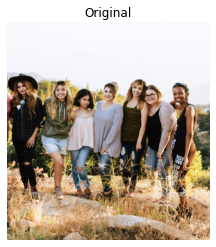

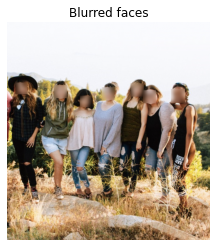

In [26]:
#from skimage.feature import Cascade
#from skimage.filters import gaussian
show_image(friends_image2, "Original")

detected = detector.detect_multi_scale(img = friends_image2,
                                       scale_factor = 1.2,
                                       step_ratio = 1,
                                       min_size = (10, 10),
                                       max_size = (200, 200))
# For each detected face
for d in detected:
    # Obtain the face cropped from detected coordinates
    face = getFaceRectangle(friends_image2, d)

    # Apply gaussian filter to extracted face
    gaussian_face = gaussian(face, multichannel= True, sigma= 10)

    # Merge this blurry face to our final image and show it
    resulting_image = mergeBlurryFace(friends_image2, gaussian_face)
show_image(resulting_image, "Blurred faces")


/Users/abigailmorgan/opt/anaconda3/lib/python3.8/site-packages/skimage/color/colorlabel.py:168: FutureWarning: Non RGB image conversion is now deprecated. For RGBA images, please use rgb2gray(rgba2rgb(rgb)) instead. In version 0.19, a ValueError will be raised if input image last dimension length is not 3.
  image = img_as_float(rgb2gray(image))